In [830]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score

In [831]:
%matplotlib inline
%config Completer.use_jedi = False

In [832]:
dataset_path = "data/mammographic_masses.data"
dataset_columns = ["BI-RADS_Assessment", "Age", "Shape", "Margin", "Density", "Severity"]

In [833]:
dataset = pd.read_csv(dataset_path, names=dataset_columns)

# 1. Preprocessing

## a. Data exploration

In [834]:
# BI-RADS_RADS_Assessment shows how confident the severity classification was. 
# We drop this, as this gives away label information and hence is not "predictive"

dataset.drop(columns=["BI-RADS_Assessment"], axis=1, inplace=True)

In [835]:
dataset.head()

,Age,Shape,Margin,Density,Severity
0,67,3,5,3,1
1,43,1,1,?,1
2,58,4,5,3,1
3,28,1,1,3,0
4,74,1,5,?,1


In [836]:
dataset.describe(include=("all"))

,Age,Shape,Margin,Density,Severity
count,961,961,961,961,961.000000
unique,74,5,6,5,NaN
top,59,4,1,3,NaN
freq,36,400,357,798,NaN
mean,NaN,NaN,NaN,NaN,0.463059
std,NaN,NaN,NaN,NaN,0.498893
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,1.000000


## b. Missing values

In [837]:
# Given dataset has ? for nulls. Replacing them with NaNs
dataset = dataset.replace("?", np.NaN).astype("float")

In [838]:
# Summary of the NaNs in the dataset
dataset.isna().sum()

Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

In [839]:
dict_datasets = {}

#### Approach 1 : Dropping rows with missing values

In [840]:
dataset_dropped_nulls = dataset.dropna()

In [841]:
dataset_dropped_nulls.describe(include=("all"))

,Age,Shape,Margin,Density,Severity
count,831.000000,831.000000,831.000000,831.000000,831.000000
mean,55.777377,2.783394,2.814681,2.915764,0.484958
std,14.663528,1.242331,1.566771,0.350737,0.500075
min,18.000000,1.000000,1.000000,1.000000,0.000000
25%,46.000000,2.000000,1.000000,3.000000,0.000000
50%,57.000000,3.000000,3.000000,3.000000,0.000000
75%,66.000000,4.000000,4.000000,3.000000,1.000000
max,96.000000,4.000000,5.000000,4.000000,1.000000


In [842]:
dict_datasets["dataset_dropped_nulls"] = dataset_dropped_nulls

#### Approach 2: Imputing missing values

In [843]:
dataset_imputed_nulls = dataset.copy()

In [844]:
# impute age and density cols (ordinal)
ordinal_cols = ["Age", "Density"]
for col in ordinal_cols:
    dataset_imputed_nulls[col] = dataset_imputed_nulls[col].fillna(dataset_imputed_nulls[col].mean().round(0))

In [845]:
# impute remaining nominal cols (Shape, Margin)

# rule strategy (Filling NaNs with 0)
dict_datasets[f"dataset_rule_imputed_nulls"] = dataset_imputed_nulls.fillna(0)

# simple imputing strategy (Filling NaNs with most frequent value for that columns)  
from sklearn.impute import SimpleImputer

simple_imputer = SimpleImputer(strategy="most_frequent")
imputed_data = simple_imputer.fit_transform(dataset_imputed_nulls.values)
dataset_simp_imputed_nulls = pd.DataFrame.from_records(imputed_data, columns=dataset_imputed_nulls.columns)
dict_datasets[f"dataset_simp_imputed_nulls"] = dataset_simp_imputed_nulls

In [846]:
for df in dict_datasets.values():
    assert df.isna().values.any() == False

In [847]:
dataset_imputed_nulls.fillna(0).describe(include=("all"))

,Age,Shape,Margin,Density,Severity
count,961.000000,961.000000,961.000000,961.000000,961.000000
mean,55.484912,2.633715,2.656608,2.917794,0.463059
std,14.442416,1.313816,1.644017,0.365869,0.498893
min,18.000000,0.000000,0.000000,1.000000,0.000000
25%,45.000000,1.000000,1.000000,3.000000,0.000000
50%,57.000000,3.000000,3.000000,3.000000,0.000000
75%,66.000000,4.000000,4.000000,3.000000,1.000000
max,96.000000,4.000000,5.000000,4.000000,1.000000


In [848]:
for key_, df in dict_datasets.items():
    print(f"----------------------------\n{key_}\n----------------------------")
    print(df.describe(include=("all")))

----------------------------
dataset_dropped_nulls
----------------------------
              Age       Shape      Margin     Density    Severity
count  831.000000  831.000000  831.000000  831.000000  831.000000
mean    55.777377    2.783394    2.814681    2.915764    0.484958
std     14.663528    1.242331    1.566771    0.350737    0.500075
min     18.000000    1.000000    1.000000    1.000000    0.000000
25%     46.000000    2.000000    1.000000    3.000000    0.000000
50%     57.000000    3.000000    3.000000    3.000000    0.000000
75%     66.000000    4.000000    4.000000    3.000000    1.000000
max     96.000000    4.000000    5.000000    4.000000    1.000000
----------------------------
dataset_rule_imputed_nulls
----------------------------
              Age       Shape      Margin     Density    Severity
count  961.000000  961.000000  961.000000  961.000000  961.000000
mean    55.484912    2.633715    2.656608    2.917794    0.463059
std     14.442416    1.313816    1.644017  

## c. Feature analysis

#### Feature histograms

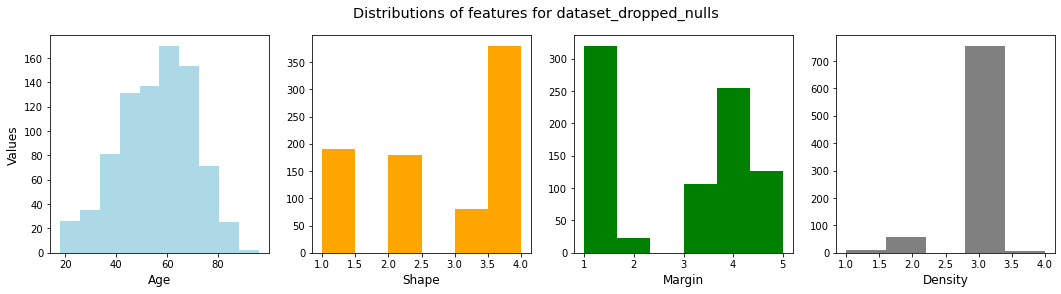

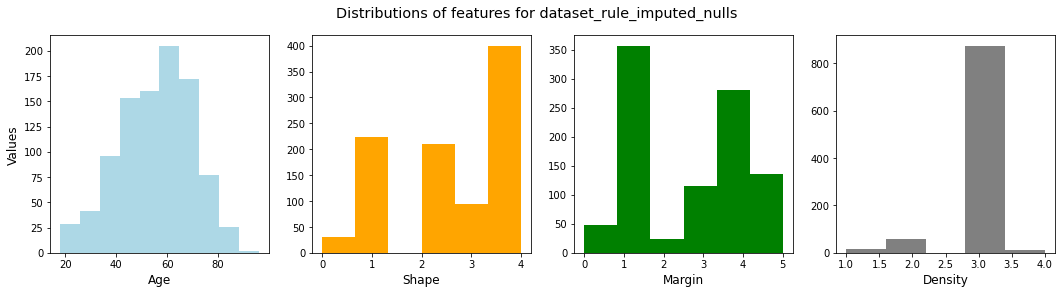

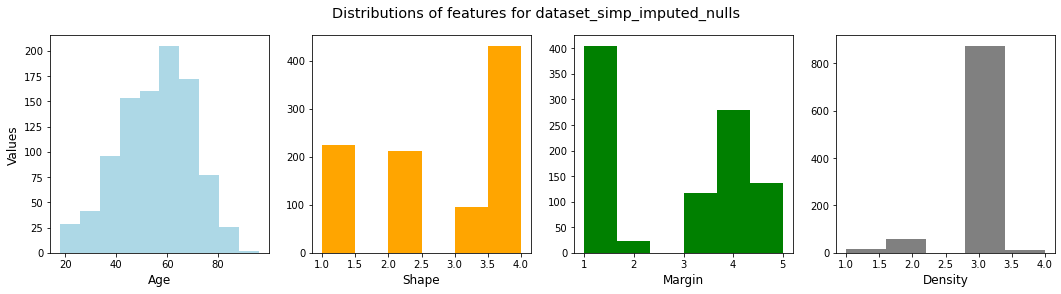

In [849]:
for key_, dataset_ in dict_datasets.items():
    fig, axes = plt.subplots(1,4, sharey=False, figsize=(18,4))
    ax1, ax2, ax3, ax4 = axes.flatten()

    ax1.hist(dataset_["Age"], bins=10, color="lightblue")
    ax2.hist(dataset_["Shape"], bins=6, color="orange")
    ax3.hist(dataset_["Margin"], bins=6, color="green")
    ax4.hist(dataset_["Density"], bins=5, color="gray")
    ax1.set_xlabel("Age", fontsize="large")
    ax2.set_xlabel("Shape", fontsize="large")
    ax3.set_xlabel("Margin", fontsize="large")
    ax4.set_xlabel("Density", fontsize="large")
    ax1.set_ylabel("Values", fontsize="large")

    plt.suptitle(f"Distributions of features for {key_}", ha="center", fontsize="x-large");

#### Principal Component Analysis (PCA)

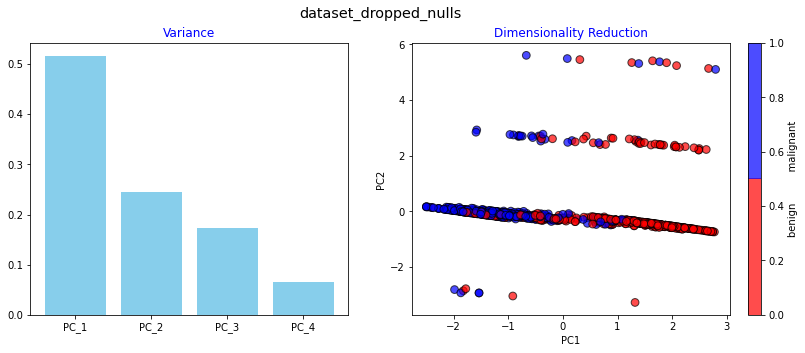

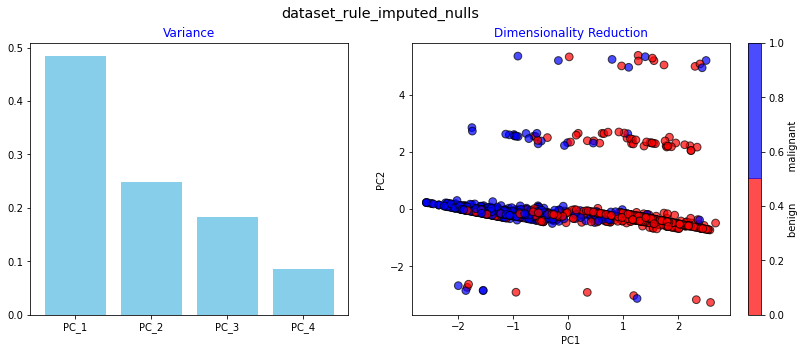

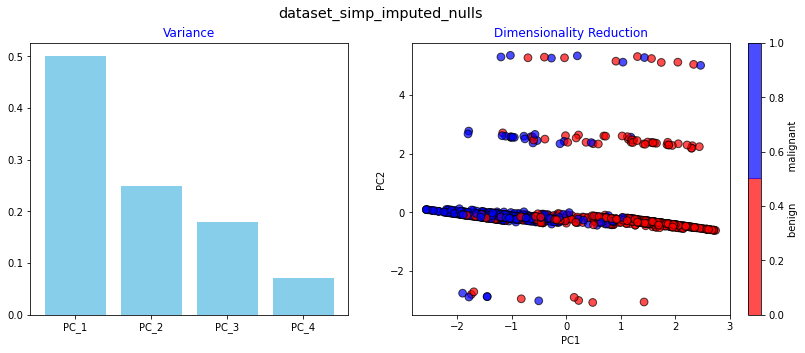

In [850]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

for key_, dataset in dict_datasets.items():
    fig, axes = plt.subplots(1,2, sharey=False, figsize=(18,5))
    ax1, ax2 = axes.flatten()
    class_ = dataset["Severity"]
    features_ = dataset.drop(columns=["Severity"], axis=1)
    normalized_features = (features_-features_.mean())/features_.std()
    pca = PCA()
    data = pca.fit_transform(normalized_features.values)
    variances = pca.explained_variance_ratio_
    components = [f"PC_{index+1}" for index,_ in enumerate(features_.columns)]
    ax1.bar(components, variances, color="skyblue")
    ax1.set_title(f"Variance", color="b", fontsize="large")
    
    # Dimensionality reduction
    ax2.scatter(data[:, 0], data[:, 1], c=class_.values, edgecolor='k',s=60, alpha=0.7, cmap=ListedColormap(('r','b')))
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.set_title("Dimensionality Reduction", color="b", fontsize="large")
    plt.colorbar(ax2.get_children()[0], label='benign'+" "*10+'malignant', ax=fig.get_axes())
    fig.suptitle(key_, ha="center", fontsize="x-large")
    plt.subplots_adjust(left=0.23, right=0.77)


## d. Nominal data

In [851]:
# Dummy encoding
nominal_cols = ["Margin"]
for key_, dataset_ in dict_datasets.items():
    dataset_ = pd.concat([dataset_, pd.get_dummies(dataset_[nominal_cols].astype(str), drop_first=True)], axis=1)
    dataset_.drop(columns=nominal_cols, axis=1, inplace=True)
    dict_datasets[key_] = dataset_

## e. Label extraction

In [852]:
dict_X_y = {}

for key_, dataset_ in dict_datasets.items():
    y_labels = ["Severity"]
    X_features = [col for col in dataset_.columns if col not in y_labels]

    X = dataset_[X_features].values
    y = dataset_[y_labels].values.reshape(-1,)
    dict_X_y[key_] = (X, y)

In [853]:
print("Shapes")
for key_, data in dict_X_y.items():
    print(f"----------------------------\n{key_}\n----------------------------")
    print(f"X: {data[0].shape}, y: {data[1].shape}")

Shapes
----------------------------
dataset_dropped_nulls
----------------------------
X: (831, 7), y: (831,)
----------------------------
dataset_rule_imputed_nulls
----------------------------
X: (961, 8), y: (961,)
----------------------------
dataset_simp_imputed_nulls
----------------------------
X: (961, 7), y: (961,)


## f. Feature scaling

In [854]:
dict_X_y_scaled = {}
dict_X_y_scaled_mm = {}

In [855]:
from sklearn.preprocessing import StandardScaler

for key_, data in dict_X_y.items():
    standard_scalar = StandardScaler()
    X_scaled = standard_scalar.fit_transform(data[0])
    dict_X_y_scaled[key_] = X_scaled, data[1]

In [856]:
from sklearn.preprocessing import MinMaxScaler

for key_, data in dict_X_y.items():
    mm_scaler = MinMaxScaler()
    X_scaled = mm_scaler.fit_transform(data[0])
    dict_X_y_scaled_mm[key_] = X_scaled, data[1]

# 2. Model Selection

In [857]:
dict_accuracies = {}
for key_ in dict_datasets:
    dict_accuracies[key_] = {}

In [858]:
from sklearn.linear_model import LogisticRegression

for key_, data in dict_X_y_scaled.items():
    log_reg_clf = LogisticRegression(solver="liblinear", random_state=0)
    score_ = cross_val_score(log_reg_clf, data[0], data[1], cv=10)
    print(f"----------------------------\n{key_}\n----------------------------")
    print(score_.mean())
    dict_accuracies[key_]["Logistic Reg."] = score_.mean()


----------------------------
dataset_dropped_nulls
----------------------------
0.8075301204819276
----------------------------
dataset_rule_imputed_nulls
----------------------------
0.7939755154639176
----------------------------
dataset_simp_imputed_nulls
----------------------------
0.7970897766323024


In [859]:
from sklearn.tree import DecisionTreeClassifier

for key_, data in dict_X_y_scaled.items():
    decision_tree_clf = DecisionTreeClassifier(random_state=0)
    score_ = cross_val_score(decision_tree_clf, data[0], data[1], cv=10)
    print(f"----------------------------\n{key_}\n----------------------------")
    print(score_.mean())
    dict_accuracies[key_]["Decision Tree"] = score_.mean()


----------------------------
dataset_dropped_nulls
----------------------------
0.7400889271371198
----------------------------
dataset_rule_imputed_nulls
----------------------------
0.7544888316151204
----------------------------
dataset_simp_imputed_nulls
----------------------------
0.7316151202749142


In [860]:
from sklearn.ensemble import RandomForestClassifier

for key_, data in dict_X_y_scaled.items():
    random_forest_clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
    score_ = cross_val_score(random_forest_clf, data[0], data[1], cv=10)
    print(f"----------------------------\n{key_}\n----------------------------")
    print(score_.mean())
    dict_accuracies[key_]["Random Forest"] = score_.mean()
    

----------------------------
dataset_dropped_nulls
----------------------------
0.7990820424555365
----------------------------
dataset_rule_imputed_nulls
----------------------------
0.8127147766323024
----------------------------
dataset_simp_imputed_nulls
----------------------------
0.7939540378006873


In [861]:
from sklearn.ensemble import GradientBoostingClassifier

for key_, data in dict_X_y_scaled.items():
    gboost_clf = GradientBoostingClassifier(n_estimators=100, max_depth=2,random_state=0)
    score_ = cross_val_score(gboost_clf, data[0], data[1], cv=10)
    print(f"----------------------------\n{key_}\n----------------------------")
    print(score_.mean())
    dict_accuracies[key_]["Grad. Boost"] = score_.mean()
    

----------------------------
dataset_dropped_nulls
----------------------------
0.7967154331612163
----------------------------
dataset_rule_imputed_nulls
----------------------------
0.8106529209621993
----------------------------
dataset_simp_imputed_nulls
----------------------------
0.7898410652920963


In [862]:
from sklearn import svm

kernels = ["linear", "rbf", "poly", "sigmoid"]
for key_, data in dict_X_y_scaled.items():
    print(f"----------------------------\n{key_}\n----------------------------")
    for kernel in kernels:
        svm_clf = svm.SVC(kernel=kernel)
        mean_score_ = cross_val_score(svm_clf, data[0], data[1], cv=10).mean()
        print(kernel, mean_score_)
        dict_accuracies[key_][f"SVM ({kernel})"] = mean_score_


----------------------------
dataset_dropped_nulls
----------------------------
linear 0.7786144578313252
rbf 0.7882816982214573
poly 0.8039300057372346
sigmoid 0.7173121055651175
----------------------------
dataset_rule_imputed_nulls
----------------------------
linear 0.7762671821305842
rbf 0.8002362542955327
poly 0.7971005154639175
sigmoid 0.7243664089347079
----------------------------
dataset_simp_imputed_nulls
----------------------------
linear 0.7762671821305842
rbf 0.7877577319587628
poly 0.8002255154639176
sigmoid 0.7378114261168385


In [863]:
from sklearn import neighbors

for key_, data in dict_X_y_scaled.items():
    best_n = 0
    best_score = -1
    print(f"----------------------------\n{key_}\n----------------------------")
    for n in range(2, 40):
        knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n)
        mean_score_ = cross_val_score(knn_clf, data[0], data[1], cv=10).mean()
        if mean_score_ > best_score:
            best_n = n
            best_score = mean_score_
    print(best_n, best_score)
    dict_accuracies[key_][f"KNN ({best_n})"] = best_score
    

----------------------------
dataset_dropped_nulls
----------------------------
7 0.7967010900745841
----------------------------
dataset_rule_imputed_nulls
----------------------------
29 0.8054445876288658
----------------------------
dataset_simp_imputed_nulls
----------------------------
33 0.7939755154639175


In [864]:
from sklearn.naive_bayes import MultinomialNB

for key_, data in dict_X_y_scaled_mm.items():
    nb_clf = MultinomialNB()
    score_ = cross_val_score(nb_clf, data[0], data[1], cv=10)
    print(f"----------------------------\n{key_}\n----------------------------")
    print(score_.mean())
    dict_accuracies[key_][f"Mul. Naive Bayes"] = score_.mean()


----------------------------
dataset_dropped_nulls
----------------------------
0.7232788296041309
----------------------------
dataset_rule_imputed_nulls
----------------------------
0.7721112542955326
----------------------------
dataset_simp_imputed_nulls
----------------------------
0.7055197594501718


In [865]:
# MLP with hyperparameter optimization using GridSearch

from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

GRID = [
    {
     'estimator__hidden_layer_sizes': [(5,), (10,), (18,), (5, 3), (5, 5), (10, 10), (20, 12)],
     'estimator__activation': ['logistic', 'tanh', 'relu'],
     'estimator__early_stopping': [True, False],
     'estimator__solver': ['adam'],
     'estimator__alpha': [0.0001, 0.001, 0.005],
     'estimator__max_iter': [1000],
    }
]

for key_, data in dict_X_y_scaled.items():
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(data[0], data[1], test_size=0.2, random_state=0)
        
    pipeline = Pipeline([('estimator', MLPClassifier(random_state=0))])
    
    grid_clf = GridSearchCV(pipeline, param_grid=GRID, n_jobs=-1)
    grid_clf.fit(X_train, y_train)
    
    print(f"----------------------------\n{key_}\n----------------------------")
    print("Best parameters set found on development set:")
    print(grid_clf.best_params_)
    
    pipeline = Pipeline([('estimator', MLPClassifier(random_state=0))])
    pipeline.set_params(**grid_clf.best_params_)
    score_ = cross_val_score(pipeline, data[0], data[1], cv=10)
    print(f"----------------------------\nCross Val Score: {score_.mean()}\n----------------------------\n")
    dict_accuracies[key_]["MLP"] = score_.mean()


----------------------------
dataset_dropped_nulls
----------------------------
Best parameters set found on development set:
{'estimator__activation': 'logistic', 'estimator__alpha': 0.0001, 'estimator__early_stopping': False, 'estimator__hidden_layer_sizes': (10,), 'estimator__max_iter': 1000, 'estimator__solver': 'adam'}
----------------------------
Cross Val Score: 0.811130235226621
----------------------------

----------------------------
dataset_rule_imputed_nulls
----------------------------
Best parameters set found on development set:
{'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__early_stopping': False, 'estimator__hidden_layer_sizes': (5, 3), 'estimator__max_iter': 1000, 'estimator__solver': 'adam'}
----------------------------
Cross Val Score: 0.7981421821305841
----------------------------

----------------------------
dataset_simp_imputed_nulls
----------------------------
Best parameters set found on development set:
{'estimator__activation': 

# 3. Model Results

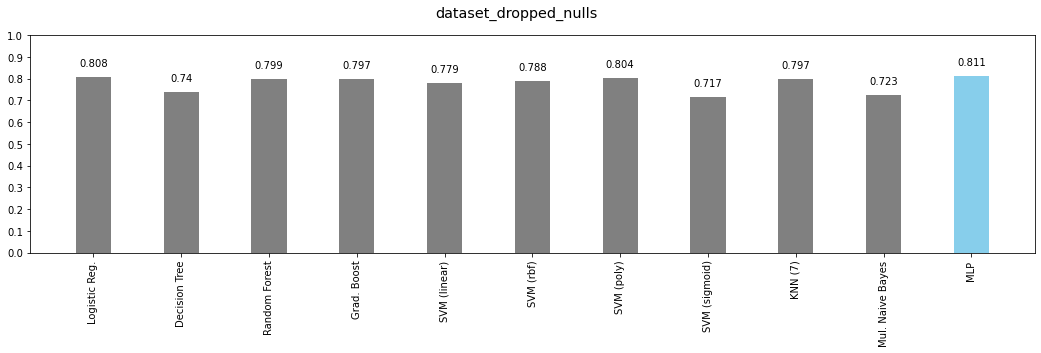

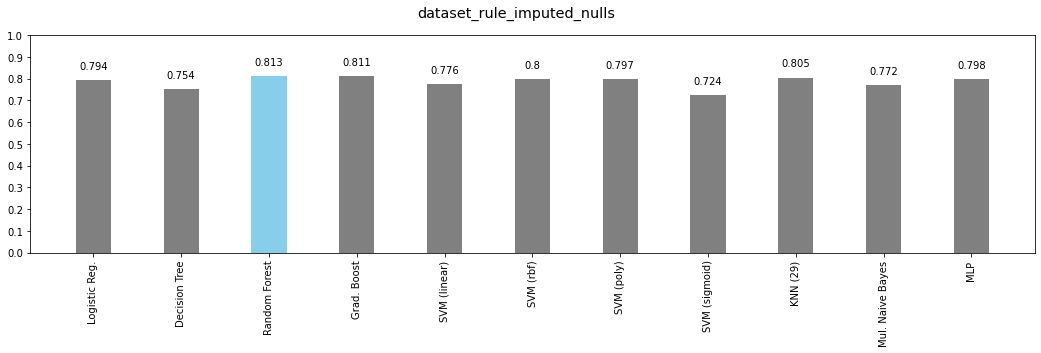

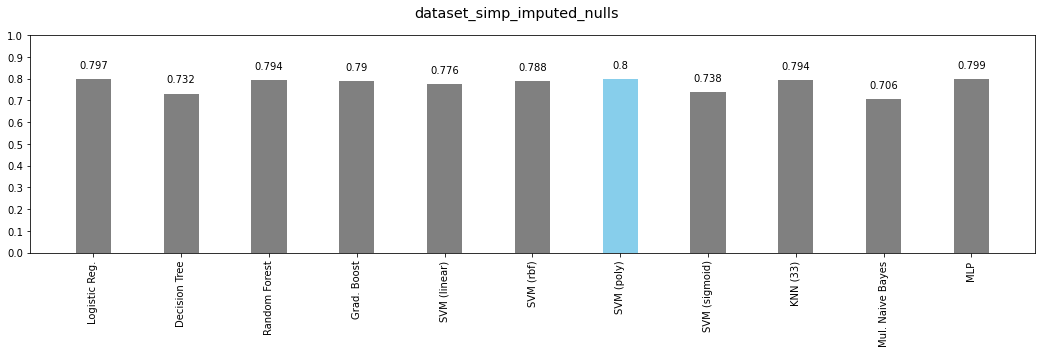

In [873]:
# comparing the results
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

for key_, dict_scores in dict_accuracies.items():
    fig, axes = plt.subplots(1,1, sharey=False, figsize=(18,4))
    models = dict_scores.keys()
    scores = dict_scores.values()
    colors = ['grey' if (x < max(scores)) else 'skyblue' for x in scores ]
    bar = plt.bar(models, scores, width=0.4, color = colors)
    plt.yticks(ticks=np.arange(0,1.1,0.1,))
    plt.xticks(rotation="vertical")
    for i, v in enumerate(scores):
        plt.text(i, v+0.05, str(round(v,3)), ha="center")
    fig.suptitle(key_, ha="center", fontsize="x-large")
